In [1]:
from research.analysis import nlp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
docs, labels = nlp.load_documents(n=1000)

In [3]:
words = nlp.load_words()
# the lexicon parameter is strict, and will likely remove names that might be important within the dataset.
# these names should be independently extracted from the source documents and added to the lexicon so they aren't
# excluded.
entity_map = nlp.extract_entity_id_map(docs, lexicon=words, extractor=nlp._text_to_tokens)

Entity count: 30409


(array([4.120e+02, 3.240e+03, 7.644e+03, 8.958e+03, 6.276e+03, 2.778e+03,
        8.720e+02, 1.880e+02, 3.400e+01, 7.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

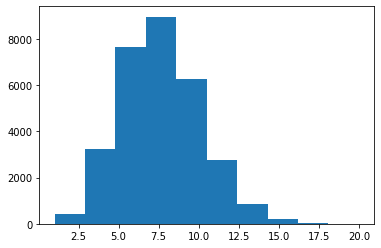

In [27]:
import numpy as np
entity_lengths = [len(e) for e in entity_map.keys()]
print("Entity count: {}".format(len(entity_lengths)))
plt.hist(entity_lengths)

In [30]:
import random
random.choices(list(entity_map.keys()), k=20)

['pros',
 'rocking',
 'deprogram',
 'panties',
 'fifo',
 'truthful',
 'foundering',
 'feeder',
 'capitalise',
 'cabot',
 'vera',
 'walkouts',
 'melting',
 'christophe',
 'synapses',
 'broom',
 'plowed',
 'unnecessary',
 'exertion',
 'register']

In [6]:
bag = nlp.bag_of_entities(docs, entity_map)

In [7]:
tfidf = nlp.tfidf(bag)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, labels, test_size=0.5, random_state=40)

In [32]:
len(y_test)

1000

In [33]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='BLM')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 10})

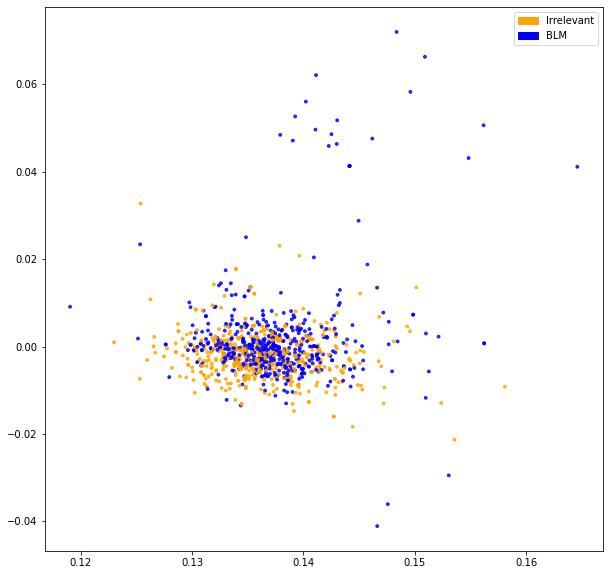

In [34]:
fig = plt.figure(figsize=(10,10))          
plot_LSA(X_train, y_train)
plt.show()

In [35]:

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1, class_weight='balanced', solver='newton-cg', random_state=41)
clf.fit(X_train, y_train)

y_predicted_counts = clf.predict(X_train)

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.507, precision = 0.507, recall = 0.507, f1 = 0.507


In [37]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=8)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

    return plt

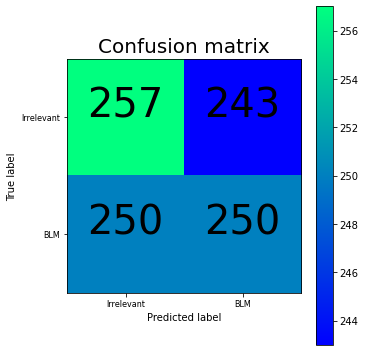

[[257 243]
 [250 250]]


In [38]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(5,5))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','BLM'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [39]:
import json
from scipy.sparse import save_npz
from research.utils import pathto

base_dir = "research/data/working_set"

In [40]:
with open(pathto(base_dir, "document_list.json"), 'w') as f:
    json.dump(docs, f)

with open(pathto(base_dir, "entity_map.json"),'w') as f:
    json.dump(entity_map, f)

save_npz(pathto(base_dir, "bag_of_words.npz"), bag)
save_npz(pathto(base_dir, "tfidf.npz"), tfidf)

In [41]:
with open(pathto(base_dir, "entity_map.json"),'r') as f:
    entity_map = json.load(f)

(array([4.120e+02, 3.240e+03, 7.644e+03, 8.958e+03, 6.276e+03, 2.778e+03,
        8.720e+02, 1.880e+02, 3.400e+01, 7.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

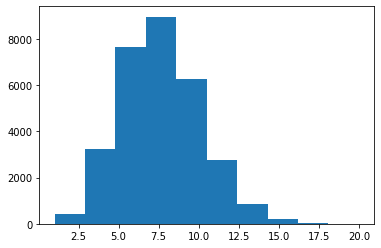

In [43]:
tokens = {w for w in entity_map.keys()}
token_lengths = [len(t) for t in tokens]
plt.hist(token_lengths)

(array([4.120e+02, 3.240e+03, 7.644e+03, 8.958e+03, 6.276e+03, 2.778e+03,
        8.720e+02, 1.880e+02, 3.400e+01, 7.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

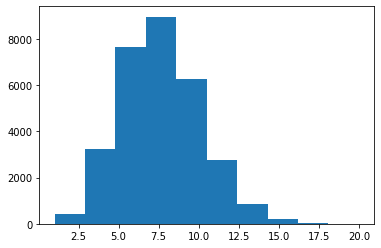

In [44]:
non_word_tokens = tokens.difference(words)
non_word_token_lengths = [len(t) for t in tokens]
plt.hist(non_word_token_lengths)

In [45]:
word_tokens = tokens.intersection(words)
word_tokens

{'successfully',
 'flips',
 'byp',
 'introspection',
 'pried',
 'town',
 'opinionated',
 'haematopoietic',
 'diner',
 'bashed',
 'ordeal',
 'distractible',
 'sprinkler',
 'astounded',
 'comas',
 'collegians',
 'ringer',
 'nigerian',
 'evacuated',
 'remain',
 'burbank',
 'kindness',
 'redfish',
 'oft',
 'preside',
 'tradesman',
 'tonic',
 'rhodes',
 'rainwater',
 'xu',
 'meno',
 'innovate',
 'musician',
 'stir',
 'complexion',
 'walnut',
 'ganges',
 'stylus',
 'prepubescent',
 'fruit',
 'profitably',
 'snap',
 'hubby',
 'flipped',
 'midterm',
 'damnedest',
 'gibbons',
 'reformation',
 'celebrate',
 'cajuns',
 'hydrothermal',
 'hole',
 'ecuador',
 'ware',
 'corralled',
 'censoring',
 'sprint',
 'borrower',
 'renewable',
 'turns',
 'fostering',
 'networking',
 'gangs',
 'marble',
 'opportunities',
 'cunt',
 'brodie',
 'tiptoes',
 'grandson',
 'councilors',
 'curiosities',
 'hangout',
 'bonder',
 'irrevocable',
 'canto',
 'conserve',
 'swim',
 'cacao',
 'reorganizing',
 'inspections',
 'sh

(array([2.58300e+03, 5.29780e+04, 1.47027e+05, 1.12537e+05, 4.39390e+04,
        9.62000e+03, 1.28700e+03, 1.17000e+02, 1.10000e+01, 5.00000e+00]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

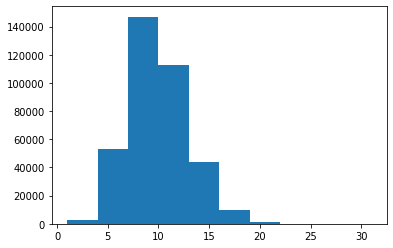

In [42]:
# how many of the 70k words, are not common words (or perhaps within a couple letters of a common word)?
from matplotlib import pyplot as plt

from research.analysis.nlp import load_words
words = load_words()

word_lengths = [len(w) for w in words]
plt.hist(word_lengths)

In [46]:
# what are the outlayers in terms of tfidf or bow scores
# - across documents
# - across words

